In [159]:
%load_ext autoreload
%autoreload 2
import os
from copy import deepcopy
import sys
from os.path import join as oj
sys.path.append('..')

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics
import matching
from tqdm import tqdm
from collections import OrderedDict
from config import *
import data
import util

# df contains filenames, ids, and attributes
df = data.load_all_labs()
df = df.set_index('fname_id')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# look at some matches

In [210]:
print([k for k in os.listdir(DIR_PROCESSED_MISC) if '14_' in k])
k_group = 'gender' # gender
matches = pd.read_pickle(oj(DIR_PROCESSED_MISC, '14_matches_gender_200.pkl'))

['14_matches_black_or_white_39.pkl', '14_matches_gender_200.pkl', '14_matches_gender_12.pkl', '14_matches_black_or_white_12.pkl']


200it [00:13, 14.86it/s]


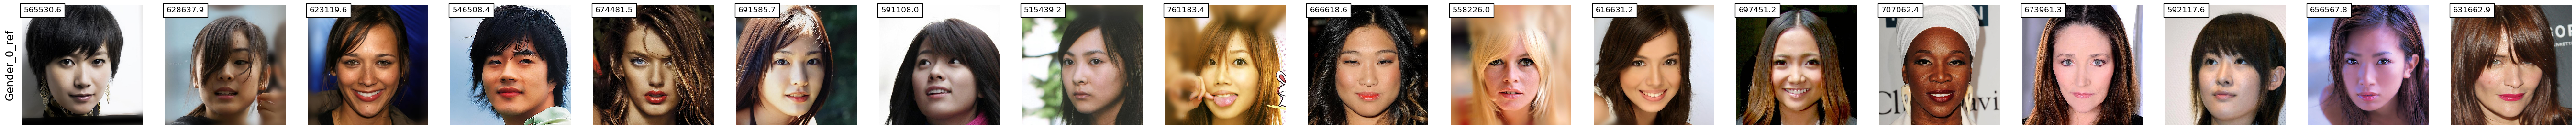

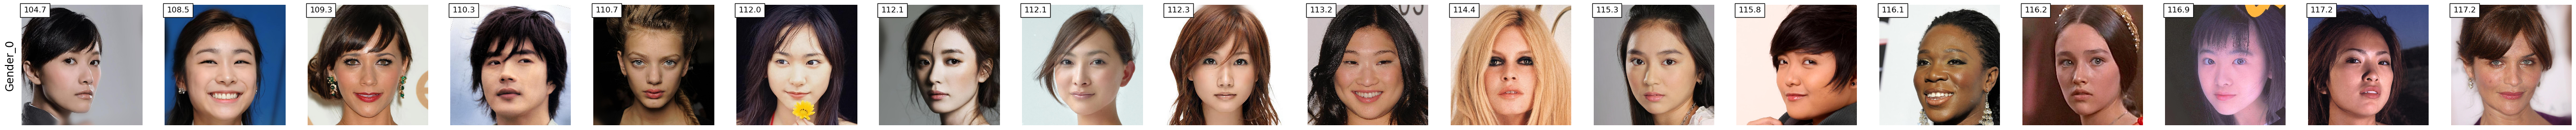

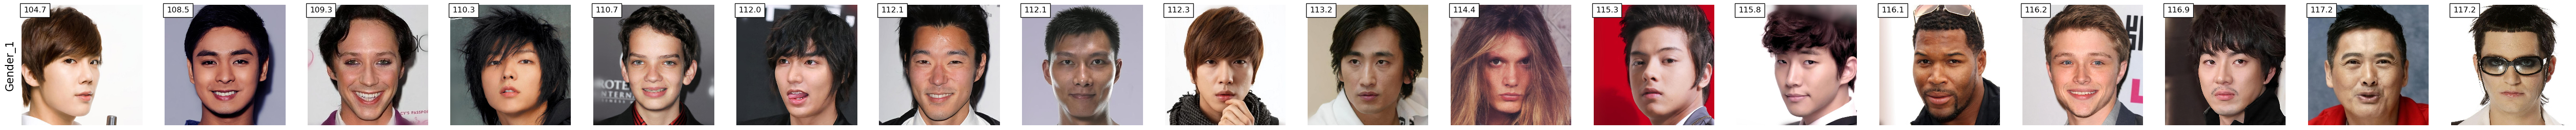

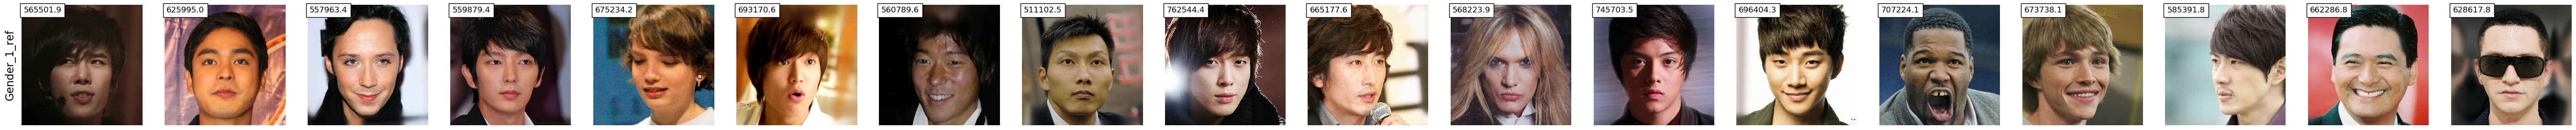

In [211]:
N_PLOT = 18
match_keys = OrderedDict({
    f'{k_group}_0_ref': 'dist_ref0',
    f'{k_group}_0': 'dist',
    f'{k_group}_1': 'dist',
    f'{k_group}_1_ref': 'dist_ref1'
})
ks = match_keys.keys()


r = {
    k: [] for k in match_keys.keys()
}
for i, match in tqdm(matches.iterrows()):
    for k in r.keys():
        d = df.iloc[int(match[k])]
        r[k].append(mpimg.imread(oj(DIR_IMS, d.fname_final)))

for i, k in enumerate(ks):
    util.plot_row(r[k][:N_PLOT],
                  annot_list=matches[match_keys[k]][:N_PLOT].round(1),
                  ylab=k.capitalize())
    plt.savefig(f'results/{k}.png', dpi=150)

# analyze mean diffs

In [245]:
def plot_subgroup_means(g0, g1, ks, ticklabels=True, args=None):
    '''
    args is used to ensure that yticks are put in same order
    '''
    if args is None:
        args = np.argsort(np.abs(g0[ks].mean() - g1[ks].mean()).values)
    for g, lab in zip([g0, g1], ['Perceived as female', 'Perceived as male']):
        means = g[ks].mean().values
        stds = 1.96 * g[ks].std().values / np.sqrt(g.shape[0])
        ys = np.arange(len(ks))
        plt.errorbar(means[args], ys, label=lab, xerr=stds[args],
                     linestyle='', marker='.', markersize=10)
        if ticklabels:
            plt.yticks(ys, [k.capitalize() for k in ks[args]])
        else:
            plt.yticks(ys, ['' for k in ks[args]])
    plt.xlim((0, 1))
    plt.grid()
    return args

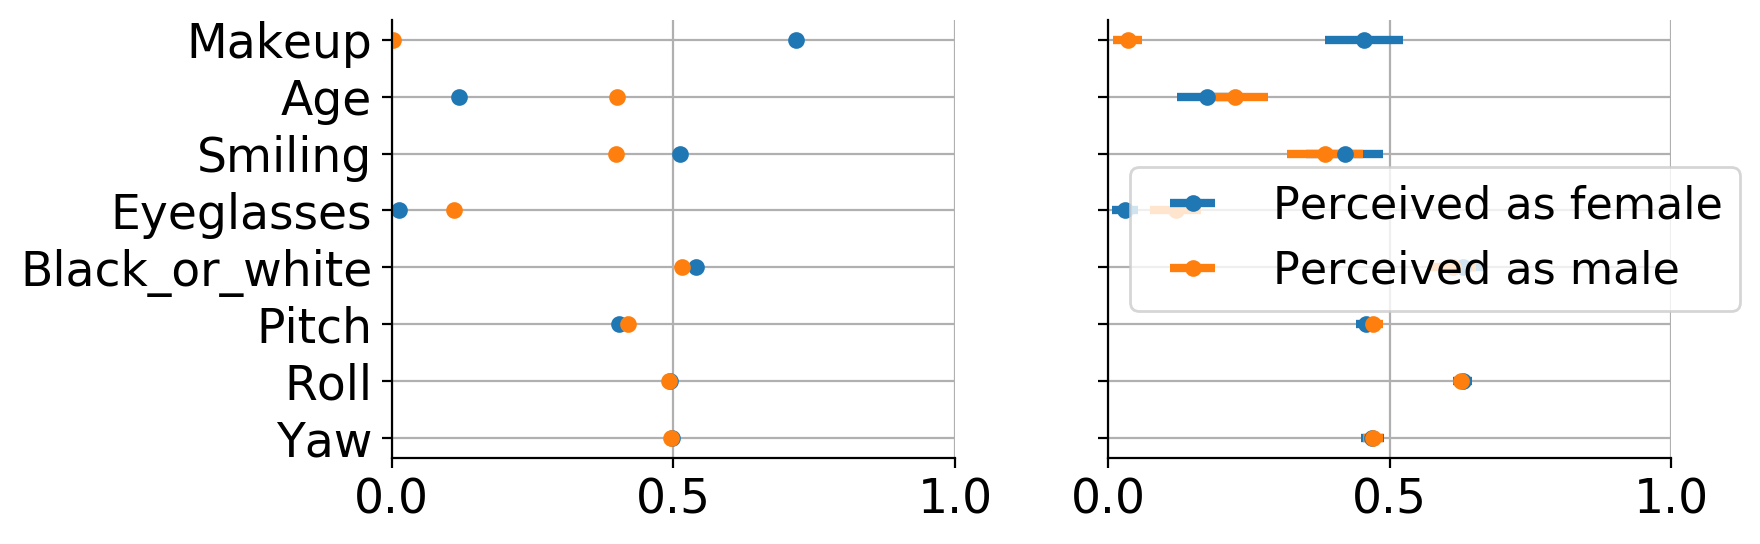

In [250]:
# match indexes are in original space [0, 30000)
# this is the same as the df.index [0, 30000)
ks_matched = [k for k in match_keys if not 'ref' in k]
idxs_matched = matches[ks_matched].values
d_matched = df.iloc[idxs_matched.flatten()]

R, C = 1, 2
plt.figure(dpi=200, figsize=(9, 3))
ks = ['yaw', 'pitch', 'roll', 'eyeglasses', 'makeup', 'gender', 'black_or_white', 'age', 'smiling']
args = None
for i, d in enumerate([df, d_matched]):
    
    d = d[ks]

    # normalize to [0, 1]
    d = (d - d.min()) / (d.max() - d.min())

    k_group = 'gender'
    
    g0 = d[d[k_group] == 0]
    g1 = d[d[k_group] == 1]
    
    plt.subplot(R, C, i + 1)
    args = plot_subgroup_means(g0, g1, ks=np.array([k for k in ks if not k == k_group]),
                        ticklabels=i == 0, args=args)
util.savefig('means_matching')
plt.legend()    
plt.show()

## look at distances for secondary matches

In [281]:
dists_ref = data.get_dists('vgg')
density = False


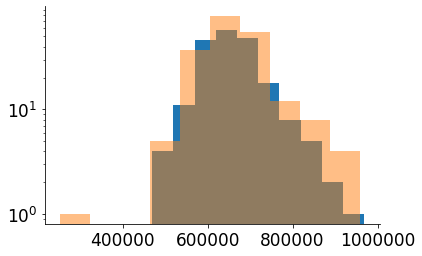

In [284]:
ks0 = [k for k in match_keys if '_0' in k]
ds_vgg0 = [dists_ref[x[0], x[1]] for x in matches[ks0].values]
ks1 = [k for k in match_keys if '1' in k]
ds_vgg1 = [dists_ref[x[0], x[1]] for x in matches[ks1].values]
plt.hist(ds_vgg0, density=density)
plt.hist(ds_vgg1, density=density, alpha=0.5)
plt.yscale('log')
plt.show()

**dists for random pairs in original data**

In [274]:
ds_orig = {
    0: [],
    1: [],
}
print('num ids', len(ids))
for val in ds_orig.keys():
    d = df[df['count_with_this_id'] > 1]
    d = d[d[k_group] == val]
    ids = sorted(d.id.unique())
    for i in tqdm(ids):
        r2 = d[d.id == i][:2].index.values # first 2 ims
        ds_orig[val].append(dists_ref[r2[0], r2[1]])

  4%|▎         | 98/2636 [00:00<00:02, 977.13it/s]

num ids 2636


100%|██████████| 1880/1880 [00:02<00:00, 933.43it/s]


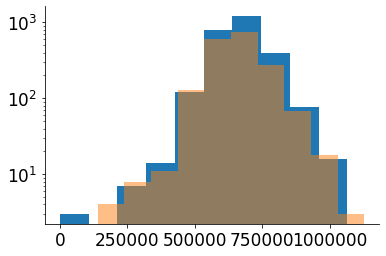

In [283]:
plt.hist(ds_orig[0], density=density)
plt.hist(ds_orig[1], density=density, alpha=0.5)
plt.yscale('log')